In [33]:
from SimPEG import Utils, Maps, Mesh
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sklim/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta', 'inv']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [34]:
# temp = np.loadtxt("../data/pohang/dem.dat")
# inds = np.logical_and(temp[:,0]>230000, temp[:,0]<233000) & np.logical_and(temp[:,1]>286500, temp[:,1]<289500)
# topo = temp[inds,:]
# np.save("../data/pohang/topo", topo)

In [35]:
topo = np.load("../data/pohang/topo.npy")

In [36]:
# temp = np.loadtxt("../data/pohang/SP_cor_allf.dat")
fid = open("../data/pohang/finalSPfield.dat")
lines = fid.readlines()
temp = []
temp_skip = []
for line in lines:
    if len(line.split()) == 4:
        temp.append(map(float, line.split()[1:]))
    else:
        print "skip data"
#         temp_skip.append(map(float, line.split()[1:]))
        print line
data = np.vstack(temp)        
# "refe1"	231829.19	287921.942
# "refe2"	231785.361	287857.776

skip data
No	X	Y	

skip data
bb39	230920.919	287935.966	



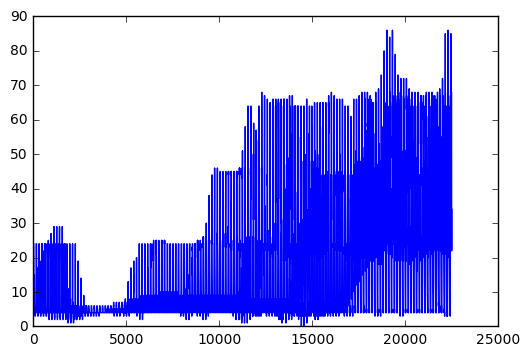

In [37]:
plt.plot(topo[:,2]-topo[:,2].min())

In [38]:
zmax = (topo[:,2]-topo[:,2].min()).max()

In [39]:
actdatinds = (data[:,0] < 233000) & (data[:,0] > 230281) & (data[:,1] > 286500) & (data[:,1] < 289500) & (data[:,2] < 40.)
xmax, xmin = data[actdatinds,0].max(), data[actdatinds,0].min()
ymax, ymin = data[actdatinds,1].max(), data[actdatinds,1].min()
xmed, ymed = 0.5*(xmax-xmin) + xmin, 0.5*(ymax-ymin) + ymin
xref, yref = 231829.19, 287921.942
xref_Inv, yref_Inv = 231829.19-xmed, 287921.942-ymed
topoInv = np.c_[topo[:,0]-xmed, topo[:,1]-ymed, topo[:,2]-topo[:,2].min()]
dataInv = np.c_[data[actdatinds,0]-xmed, data[actdatinds,1]-ymed, data[actdatinds,2]]
dataInv = np.vstack((dataInv, np.r_[xref_Inv, yref_Inv, 0.]))

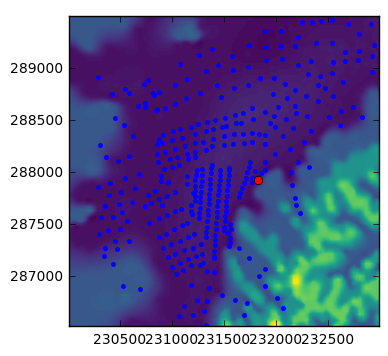

In [40]:
Utils.plot2Ddata(topo[:,:2], topo[:,2], ncontour=100, contourOpts={"cmap":"viridis"})
plt.plot(data[actdatinds,0], data[actdatinds,1], '.')
plt.plot(xref, yref, 'ro')

(<matplotlib.contour.QuadContourSet at 0x126690110>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122f66910>)

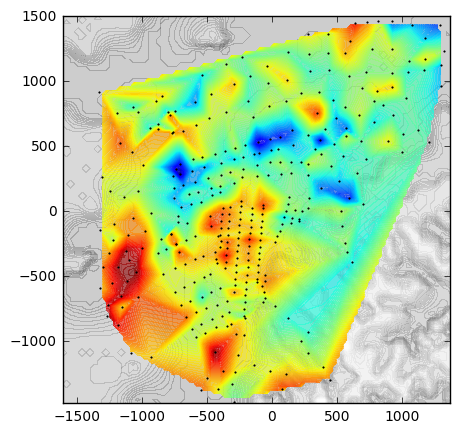

In [41]:
fig = plt.figure(figsize = (5,5))
ax = plt.subplot(111)
Utils.plot2Ddata(topoInv[:,:2], topoInv[:,2], ncontour=50, ax=ax, contourOpts={"cmap":"binary_r", "alpha":0.2})
Utils.plot2Ddata(dataInv[:,:2], dataInv[:,2], ncontour=100, contourOpts={"cmap":"jet", "alpha":0.6}, dataloc=True, ax=ax)

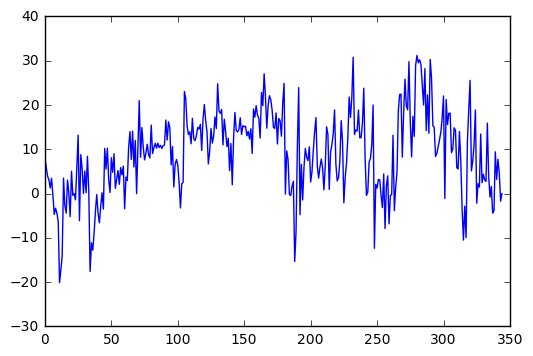

In [42]:
plt.plot(dataInv[:,2])

In [43]:
dx = 50.
dz = 20.
npad = 5
hxind = [(dx, npad, -1.3), (dx, 60), (dx, npad, 1.3)]
hyind = [(dx, npad, -1.3), (dx, 60), (dx, npad, 1.3)]
hzind = [(dz, npad, -1.3), (dz, 10), (dz*0.8, 16)]
mesh = Mesh.TensorMesh([hxind, hyind, hzind], "CCN")
mesh._x0 = np.r_[mesh.x0[0], mesh.x0[1], mesh.x0[2]+zmax] 

In [44]:
mesh.hz[:3].sum()

175.32060000000001

In [45]:
from SimPEG.EM.Static.Utils import StaticUtils

In [46]:
print mesh

  ---- 3-D TensorMesh ----  
   x0: -2087.80
   y0: -2087.80
   z0: -605.12
  nCx: 70
  nCy: 70
  nCz: 31
   hx: 185.65, 142.81, 109.85, 84.50, 65.00, 60*50.00, 65.00, 84.50, 109.85, 142.81, 185.65
   hy: 185.65, 142.81, 109.85, 84.50, 65.00, 60*50.00, 65.00, 84.50, 109.85, 142.81, 185.65
   hz: 74.26, 57.12, 43.94, 33.80, 26.00, 10*20.00, 16*16.00


In [47]:
from scipy.sparse import block_diag

In [48]:
actind = Utils.surface2ind_topo(mesh, topoInv, gridLoc="N")
actMap = Maps.InjectActiveCells(mesh, actind, 0.)
mesh2D, topoCC = StaticUtils.gettopoCC(mesh, ~actind)

(<matplotlib.collections.QuadMesh at 0x13ca3f1d0>,)

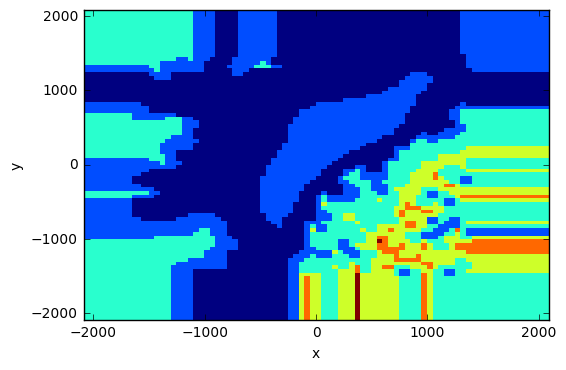

In [49]:
mesh2D.plotImage(topoCC)

In [50]:
xyzlocInv = StaticUtils.drapeTopotoLoc(mesh, topoInv, dataInv[:,:2], airind=actind)
xyzlocInv = np.c_[xyzlocInv[:,:2], xyzlocInv[:,2]]

In [51]:
sigma = np.ones(mesh.nC)*1e-3
sigma[~actind] = 1e-8


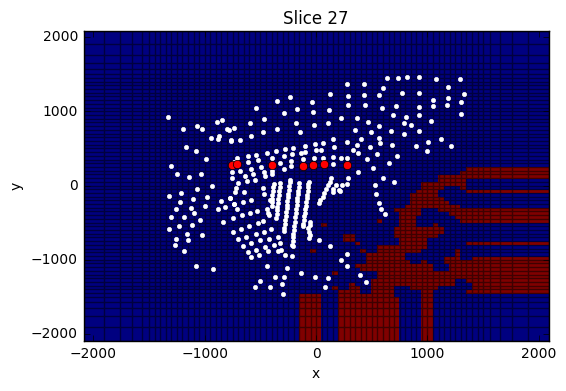

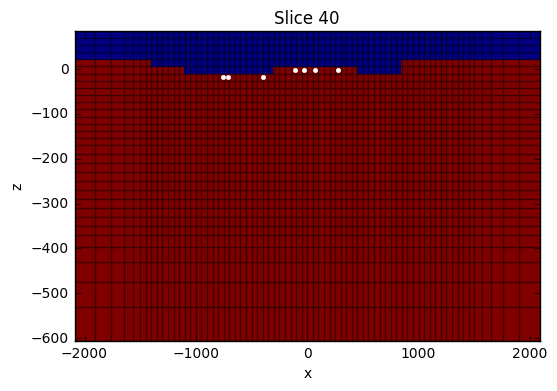

In [52]:
indy = 40
indstemp = abs(xyzlocInv[:,1]-mesh.vectorCCy[indy]) < 10.
mesh.plotSlice(actind, normal="Z", ind=27, grid=True)
plt.plot(dataInv[:,0], dataInv[:,1], 'w.')
plt.plot(dataInv[indstemp,0], dataInv[indstemp,1], 'ro')

mesh.plotSlice(sigma, normal="Y", grid=True, ind = indy)
plt.plot(xyzlocInv[indstemp,0], xyzlocInv[indstemp,2], 'w.')

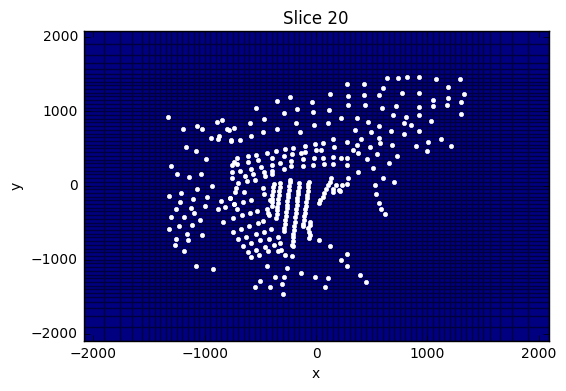

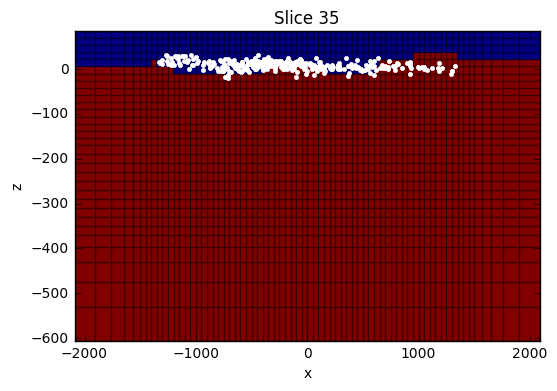

In [53]:
mesh.plotSlice(actind, normal="Z", ind=20, grid=True)
plt.plot(dataInv[:,0], dataInv[:,1], 'w.')
mesh.plotSlice(actind, normal="Y", grid=True)
plt.plot(dataInv[:,0], dataInv[:,2], 'w.')

In [54]:
zlocCC = Utils.mkvc(topoCC.reshape([-1,1]).repeat(mesh.nCz, axis=1))
depthweight = 1./ ((abs(mesh.gridCC[:,2] - zlocCC)+2.5)**1.)
depthweight /= depthweight.max()
depthweight[~actind] = np.nan
zlocCC[~actind] = np.nan

(<matplotlib.collections.QuadMesh at 0x131261910>,
 <matplotlib.lines.Line2D at 0x131261e90>)

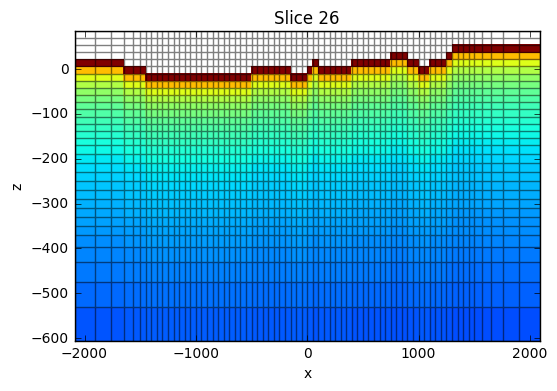

In [55]:
mesh.plotSlice(np.log10(depthweight), normal="Y", grid=True, clim=(-3, 0), ind=26)

In [56]:
import simpegSP as SP
from pymatsolver import PardisoSolver
from SimPEG.EM.Static.SIP.Regularization import MultiRegularization

xyzM = xyzlocInv[:-1,:]
xyzN = np.atleast_2d(xyzlocInv[-1,:]).repeat(xyzM.shape[0], axis=0)
wires = Maps.Wires(('jsx', actMap.nP), ('jsy', actMap.nP), ('jsz', actMap.nP))
prb = SP.Problem_CC(mesh, sigma=sigma, jsxMap=actMap*wires.jsx, jsyMap=actMap*wires.jsy, jszMap=actMap*wires.jsz, Solver=PardisoSolver)
rx = SP.Rx.Dipole(xyzN, xyzM)
src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh.nC)*1e-6, mesh=mesh, modelType="CurrentDensity")
survey = SP.Survey([src])
survey.pair(prb)

In [57]:
survey.dobs = dataInv[:-1,2]

In [58]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
survey.std = 0.
survey.eps = abs(survey.dobs).max() * 0.05

dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(nP = actMap.nP*3)
reg = MultiRegularization(mesh, mapping=regmap ,nModels=3, indActive=actind)
reg.cell_weights = depthweight[actind] 
reg.alpha_s = 1.
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
reg.ratios = [1., 1., 0.1]
opt = Optimization.InexactGaussNewton(maxIter=15, tolX=1e-20, tolF=1e-20)
opt.maxIterCG = 3
opt.maxIterLS = 30
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
target = Directives.TargetMisfit()
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig()
betaest.beta0_ratio = 2.
invProb.beta = 1e0
inv = Inversion.BaseInversion(invProb, directiveList=[beta, target])
prb.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
m0 = np.ones(actMap.nP*3)*0.
reg.mref = m0
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.19e+04  0.00e+00  1.19e+04    1.19e+10      0              
   1  1.00e+00  1.09e+04  5.00e-12  1.09e+04    2.11e+04      0              
   2  1.00e+00  6.01e+03  3.60e+01  6.04e+03    2.56e+05      0   Skip BFGS  
   3  2.00e-01  6.01e+03  3.60e+01  6.01e+03    2.56e+05     19              
   4  2.00e-01  6.01e+03  3.60e+01  6.01e+03    1.28e+05      1              
   5  2.00e-01  4.99e+03  7.68e+01  5.00e+03    4.24e+03      0              
   6  4.00e-02  4.69e+03  8.92e+01  4.69e+03    2.06e+08      0              
   7  4.00e-02  4.55e+03  1.07e

(<matplotlib.contour.QuadContourSet at 0x12ff9f9d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13077bc50>)

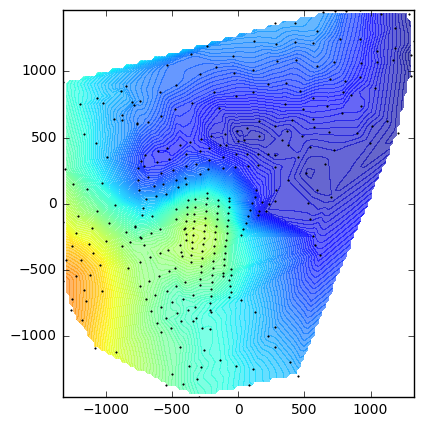

In [59]:
fig = plt.figure(figsize = (5,5))
ax = plt.subplot(111)
vmin, vmax = invProb.dpred.min(), invProb.dpred.max()*1.3
Utils.plot2Ddata(xyzM[:,:2], invProb.dpred, ncontour=100, contourOpts={"cmap":"jet", "alpha":0.6, "vmin":vmin, "vmax":vmax}, dataloc=True, ax=ax)

In [65]:
dpred10  = survey.dpred(xc[10])

NameError: name 'xc' is not defined

NameError: name 'dpred10' is not defined

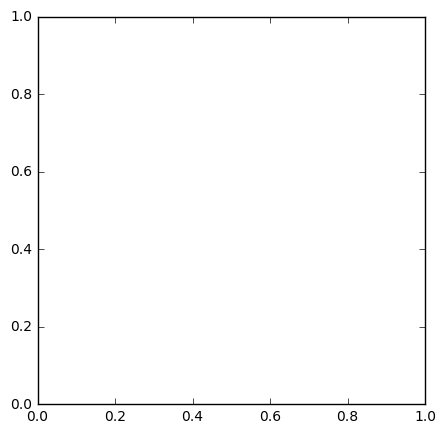

In [63]:
fig = plt.figure(figsize = (5,5))
ax = plt.subplot(111)
vmin, vmax = dpred10.min(), dpred10.max()*1.3
Utils.plot2Ddata(xyzM[:,:2], dpred10, ncontour=100, contourOpts={"cmap":"jet", "alpha":0.6, "vmin":vmin, "vmax":vmax}, dataloc=True, ax=ax)

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = plt.subplot(111)
Utils.plot2Ddata(xyzM[:,:2], survey.dobs, ncontour=100, contourOpts={"cmap":"jet", "alpha":0.6, "vmin":vmin, "vmax":vmax}, dataloc=True, ax=ax)

In [ ]:
plt.plot(dpred10)
plt.plot(survey.dobs)

In [ ]:
iteration = 10
xc = opt.recall("xc")
temp = xc[iteration].reshape((actMap.nP, 3), order="F")
tempx = actMap * temp[:,0]
tempy = actMap * temp[:,1]
tempz = actMap * temp[:,2]
temp_amp = np.sqrt(temp[:,0]**2 + temp[:,1]**2 + temp[:,2]**2)
tempx[~actind] = np.nan
tempy[~actind] = np.nan
tempz[~actind] = np.nan
temp = np.c_[tempx, tempy, tempz]

In [ ]:
temp_amp.min()
temp_amp.max()

In [ ]:
actMap_plot = Maps.InjectActiveCells(mesh, actind, np.nan)
indz = 15
mesh.plotSlice((actMap_plot*temp_amp), ind = 15, clim=(0, temp_amp.max()), normal="Z")
mesh.plotSlice(temp, clim=(0, temp_amp.max()), normal="Y", vType='CCv', view='vec', ind=32)
print mesh.vectorCCz[indz]

In [ ]:
indz, indy = 17, 31
mesh.plotSlice((actMap_plot*temp_amp), ind = indz, clim=(0, temp_amp.max()), normal="Z")
plt.ylim(-1500, 1500)
plt.xlim(-1500, 1500)
plt.gca().set_aspect("equal")

In [ ]:
mesh.plotSlice((actMap_plot*temp_amp), clim=(0, temp_amp.max()), normal="Y", ind=indy)
plt.xlim(-1500, 1500)
plt.ylim(-300, 90)
plt.gca().set_aspect(2)
print mesh.vectorCCz[indz]
print mesh.vectorCCy[indy]

In [ ]:
mesh.plotSlice(temp, clim=(0, temp_amp.max()), normal="Y", vType='CCv', view='vec', ind=32, streamOpts={"color":'w'})
print mesh.vectorCCz[indz]
plt.xlim(-1500, 1500)
plt.ylim(-300, 90)
plt.gca().set_aspect(2)


In [ ]:
mesh.plotSlice(tempx, normal="X", grid=True, ind=19)

In [ ]:
mesh.writeVTK("pohang", models={"sigma":sigma, "amp":actMap_plot*temp_amp, "j":np.c_[tempx, tempy, tempz]})
# np.savetxt("topoxyz.csv", topoInv, delimiter=",", header="xcoord, ycoord, zcoord")
# np.savetxt("dataxyz.csv", out, delimiter=",", header="xcoord, ycoord, zcoord")

In [ ]:
actMap_plot*temp_amp

In [ ]:
temp_amp.min()

In [ ]:
temp_amp.max()